In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter, defaultdict
import torch
import warnings
warnings.filterwarnings('ignore')

In [3]:
df0 = pd.read_csv('./spike_mutations_frequency_1000.csv', header = 0)

## Var cal

In [4]:
stats = defaultdict(Counter)

for i in range(303-13+1):
    stats['NTD'][13+i] = 0

for i in range(541-319+1):
    stats['RBD'][319+i] = 0

for i in range(806-788+1):
    stats['FP'][788+i] = 0

for i in range(984-912+1):
    stats['HR1'][912+i] = 0

for i in range(1213-1163+1):
    stats['HR2'][1163+i] = 0

In [5]:
for i in range(len(df0)):
    if df0['site'][i] >12 and df0['site'][i] < 304:
        stats['NTD'][df0['site'][i]] += 1
    elif df0['site'][i] >318 and df0['site'][i] < 542:
        stats['RBD'][df0['site'][i]] += 1
    elif df0['site'][i] >787 and df0['site'][i] < 807:
        stats['FP'][df0['site'][i]] += 1
    elif df0['site'][i] >911 and df0['site'][i] < 985:
        stats['HR1'][df0['site'][i]] += 1
    elif df0['site'][i] >1162 and df0['site'][i] < 1214:
        stats['HR2'][df0['site'][i]] += 1

In [6]:
df_NTD = pd.DataFrame(stats['NTD'].items(), columns = ['sites', 'mutation_type'])
df_RBD = pd.DataFrame(stats['RBD'].items(), columns = ['sites', 'mutation_type'])
df_FP = pd.DataFrame(stats['FP'].items(), columns = ['sites', 'mutation_type'])
df_HR1 = pd.DataFrame(stats['HR1'].items(), columns = ['sites', 'mutation_type'])
df_HR2 = pd.DataFrame(stats['HR2'].items(), columns = ['sites', 'mutation_type'])

In [7]:
print('NTD var = ', str(df_NTD['mutation_type'].var()))
print('RBD var = ', str(df_RBD['mutation_type'].var()))
print('FP var = ', str(df_FP['mutation_type'].var()))
print('HR1 var = ', str(df_HR1['mutation_type'].var()))
print('HR2 var = ', str(df_HR2['mutation_type'].var()))

NTD var =  4.026448631354426
RBD var =  1.5604977174483885
FP var =  0.35672514619883056
HR1 var =  0.8356164383561646
HR2 var =  0.7937254901960781


## heatmap of freq

In [8]:
df = df0.sort_values(by='site')

In [9]:
df['domain'] = ''
for i in range(len(df)):
    if df['site'][i] >12 and df['site'][i] < 304:
        df['domain'][i] = 'NTD'
    elif df['site'][i] >318 and df['site'][i] < 542:
        df['domain'][i] = 'RBD'
    elif df['site'][i] >787 and df['site'][i] < 807:
        df['domain'][i] = 'FP'
    elif df['site'][i] >911 and df['site'][i] < 985:
        df['domain'][i] = 'HR1'
    elif df['site'][i] >1162 and df['site'][i] < 1214:
        df['domain'][i] = 'HR2'
    else:
        df['domain'][i] = 'No domain'

In [10]:
df_NTD_heatmap = pd.DataFrame(columns=['site', 'aa', 'freq'])
df_RBD_heatmap = pd.DataFrame(columns=['site', 'aa', 'freq'])
df_FP_heatmap = pd.DataFrame(columns=['site', 'aa', 'freq'])
df_HR1_heatmap = pd.DataFrame(columns=['site', 'aa', 'freq'])
df_HR2_heatmap = pd.DataFrame(columns=['site', 'aa', 'freq'])

In [11]:
for i in range(len(df)):
    if df['mutations'][i][-3:] != 'del':
        if df['domain'][i] == 'NTD':
            df_NTD_heatmap.loc[len(df_NTD_heatmap)] = [df['site'][i], df['mutations'][i][-1], df['shannon'][i]]
        if df['domain'][i] == 'RBD':
            df_RBD_heatmap.loc[len(df_RBD_heatmap)] = [df['site'][i], df['mutations'][i][-1], df['shannon'][i]]
        if df['domain'][i] == 'FP':
            df_FP_heatmap.loc[len(df_FP_heatmap)] = [df['site'][i], df['mutations'][i][-1], df['shannon'][i]]
        if df['domain'][i] == 'HR1':
            df_HR1_heatmap.loc[len(df_HR1_heatmap)] = [df['site'][i], df['mutations'][i][-1], df['shannon'][i]]
        if df['domain'][i] == 'HR2':
            df_HR2_heatmap.loc[len(df_HR2_heatmap)] = [df['site'][i], df['mutations'][i][-1], df['shannon'][i]]

In [12]:
def cal_heatmap(df_heatmap):
    columns = defaultdict(list)
    stats = defaultdict(Counter)

    for i in range(len(df_heatmap)):
        if df_heatmap['aa'][i] == ']':
            pass
        else:
            site = df_heatmap['site'][i]
            aa = df_heatmap['aa'][i]
            freq = df_heatmap['freq'][i]

            columns['aa'].append(aa)
            columns['site'].append(site)
            columns['freq'].append(freq)

            stats['aa'][aa] +=1
            stats['site'][site] +=1
            stats['aa_site'][site, aa] = freq

    columns = dict(columns)
    stats = dict(stats)

    aas = sorted(stats['aa'])
    sites = sorted(stats['site'])

    aa_site_fitness = torch.zeros(len(sites), len(aas), dtype=torch.float)
    for s, site in enumerate(sites):
        for f, aa in enumerate(aas):
            count = stats["aa_site"].get((site, aa))
            if count is None:
                count = 0
            aa_site_fitness[s, f] = float(count)
    aa_freq_sum = torch.zeros(len(sites),1,dtype=torch.float)
    for i in range(len(sites)):
        aa_freq_sum[i, :] = aa_site_fitness[i, :].sum()
    aa_site_fitness1 = aa_site_fitness/aa_freq_sum
    return aa_site_fitness1, aas, sites

Text(285.22222222222223, 0.5, 'AA Substitution')

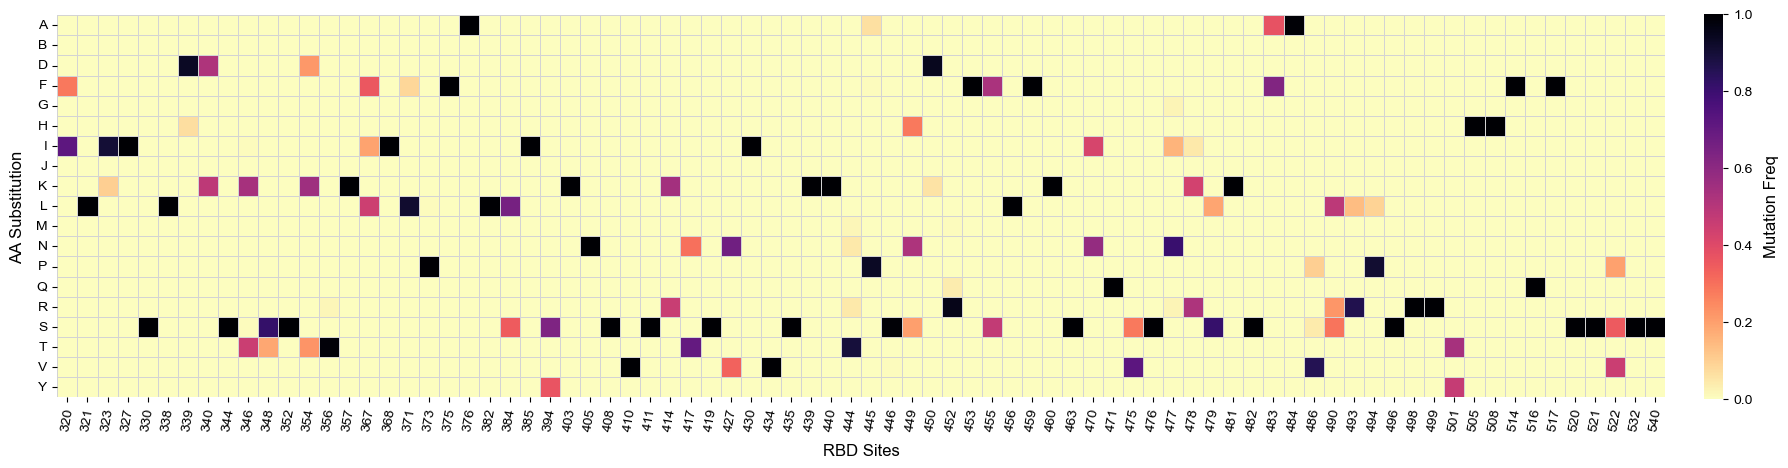

In [13]:
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

aa_site_fitness = cal_heatmap(df_RBD_heatmap)[0]
aas = cal_heatmap(df_RBD_heatmap)[1]
sites = []
for i in range(len(cal_heatmap(df_RBD_heatmap)[2])):
    sites.append(int(cal_heatmap(df_RBD_heatmap)[2][i]))

plt.figure(figsize=(25,5))
# plt.figure(figsize=(60,7))
plt.rcParams['font.sans-serif'] = ['Arial']
data = pd.DataFrame(aa_site_fitness.T)

# sites_plot = []
# for i in range(len(sites)):
#     sites_plot.append(sites[i]-13)

# data = data[sites_plot]

data = data.T
data.columns = aas
data.index = sites

data = data.T

ax = sns.heatmap(data, cmap='magma_r', square=True, linewidths=0.6, linecolor='lightgray', cbar_kws={'pad':0.02})

colorbar = ax.collections[0].colorbar
colorbar.set_label('Mutation Freq', fontsize=12, labelpad = 8)

plt.xticks(rotation=80)
plt.yticks(rotation=0)

plt.xlabel('RBD Sites', fontsize=12, labelpad = 8)
plt.ylabel('AA Substitution', fontsize=12, labelpad = 8)

# plt.savefig('/Users/leizhongyi/Code/pyro/fig1_code/fig1GH/freq100_heatmap_RBD.png', bbox_inches='tight', dpi=400)

<AxesSubplot:>

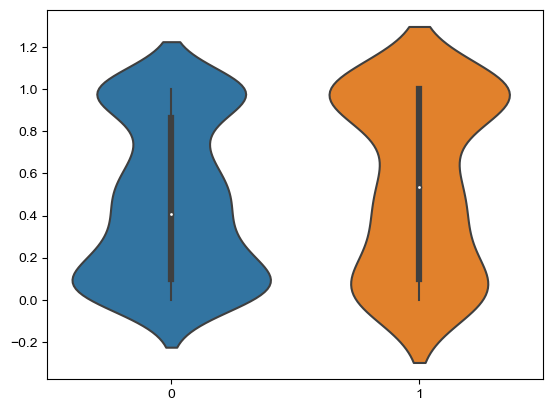

In [14]:
NTD_plot = cal_heatmap(df_NTD_heatmap)[0]
RBD_plot = cal_heatmap(df_RBD_heatmap)[0]
FP_plot = cal_heatmap(df_FP_heatmap)[0]
HR1_plot = cal_heatmap(df_HR1_heatmap)[0]
HR2_plot = cal_heatmap(df_HR2_heatmap)[0]

NTD_plot1 = []
for i in range(len(NTD_plot.view(-1))):
    if NTD_plot.view(-1)[i] != 0:
        NTD_plot1.append(NTD_plot.view(-1)[i].tolist())
RBD_plot1 = []
for i in range(len(RBD_plot.view(-1))):
    if RBD_plot.view(-1)[i] != 0:
        RBD_plot1.append(RBD_plot.view(-1)[i].tolist())
FP_plot1 = []
for i in range(len(FP_plot.view(-1))):
    if FP_plot.view(-1)[i] != 0:
        FP_plot1.append(FP_plot.view(-1)[i].tolist())
HR1_plot1 = []
for i in range(len(HR1_plot.view(-1))):
    if HR1_plot.view(-1)[i] != 0:
        HR1_plot1.append(HR1_plot.view(-1)[i].tolist())
HR2_plot1 = []
for i in range(len(HR2_plot.view(-1))):
    if HR2_plot.view(-1)[i] != 0:
        HR2_plot1.append(HR2_plot.view(-1)[i].tolist())

sns.violinplot([NTD_plot1, RBD_plot1])
# plt.ylim(0, 0.2)

<AxesSubplot:>

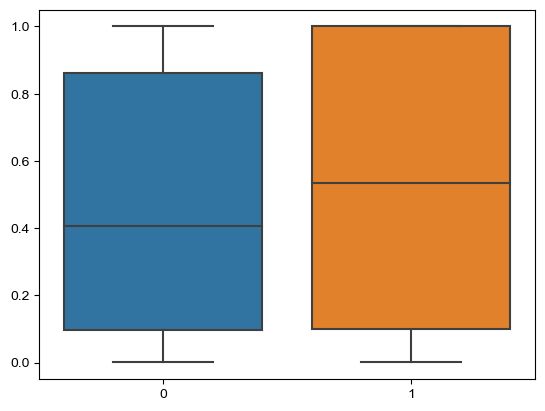

In [15]:
sns.boxplot([NTD_plot1, RBD_plot1])

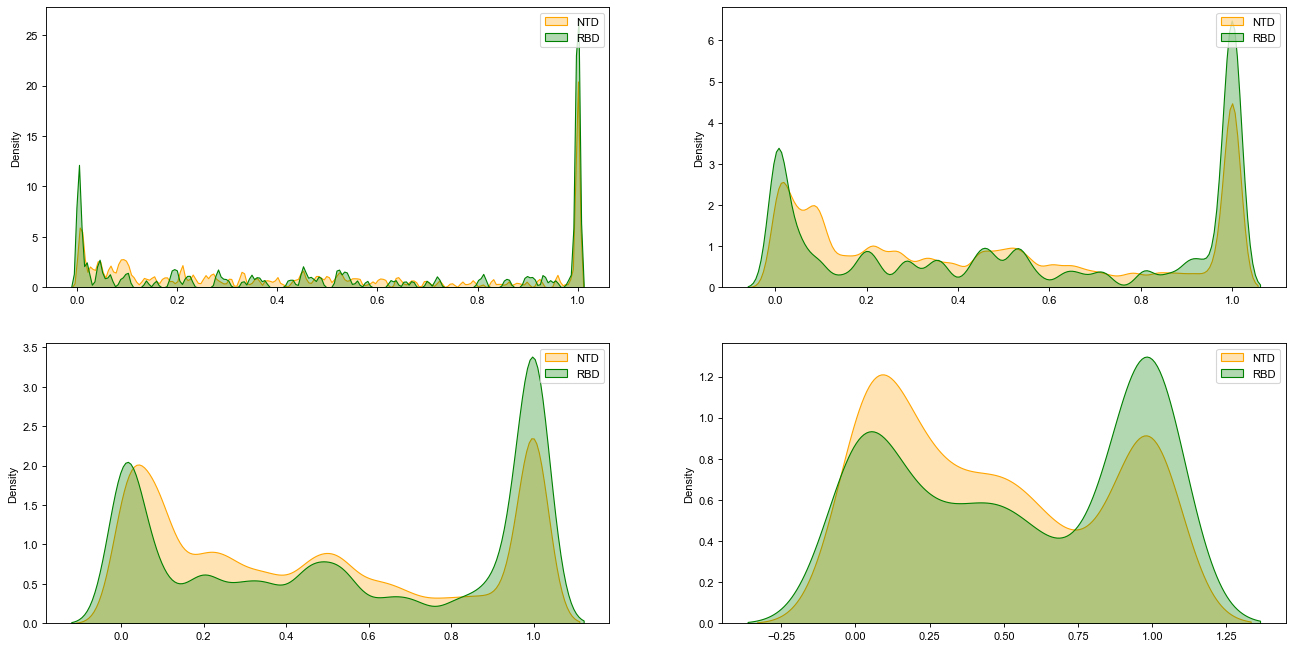

In [16]:
ax=plt.figure(figsize=(20,10), dpi= 80)
plt.subplot(221)
sns.kdeplot(NTD_plot1,shade=True, color="orange", label="NTD", alpha=.3, bw = 0.01)
sns.kdeplot(RBD_plot1,shade=True, color="green", label="RBD", alpha=.3, bw = 0.01)
plt.legend()

plt.subplot(222)
sns.kdeplot(NTD_plot1,shade=True, color="orange", label="NTD", alpha=.3, bw = 0.05)
sns.kdeplot(RBD_plot1,shade=True, color="green", label="RBD", alpha=.3, bw = 0.05)
plt.legend()

plt.subplot(223)
sns.kdeplot(NTD_plot1,shade=True, color="orange", label="NTD", alpha=.3, bw = 0.1)
sns.kdeplot(RBD_plot1,shade=True, color="green", label="RBD", alpha=.3, bw = 0.1)
plt.legend()

plt.subplot(224)
sns.kdeplot(NTD_plot1,shade=True, color="orange", label="NTD", alpha=.3, bw = 0.3)
sns.kdeplot(RBD_plot1,shade=True, color="green", label="RBD", alpha=.3, bw = 0.3)
plt.legend()

In [ ]:
df = pd.DataFrame()
df['NTD'] = pd.Series(NTD_plot1)
df['RBD'] = pd.Series(RBD_plot1)
df['FP'] = pd.Series(FP_plot1)
df['HR1'] = pd.Series(HR1_plot1)
df['HR2'] = pd.Series(HR2_plot1)

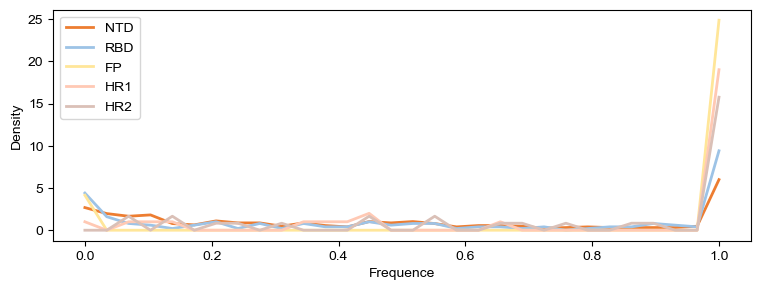

In [18]:
df = pd.read_csv('./density_S.csv', header=0)
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(9,3))

plt.plot(df['x'], df['NTD'], color = '#ED7D31', lw=2, zorder=-9, label = 'NTD')
plt.plot(df['x'], df['RBD'], color = '#9DC3E6', lw=2, zorder=-9, label = 'RBD')
plt.plot(df['x'], df['FP'], color = '#FFE699', lw=2, zorder=-9, label = 'FP')
plt.plot(df['x'], df['HR1'], color = '#FFC9B4', lw=2, zorder=-9, label = 'HR1')
plt.plot(df['x'], df['HR2'], color = '#DAC0B7', lw=2, zorder=-9, label = 'HR2')

plt.xlabel('Frequence')
plt.ylabel('Density')
plt.legend()

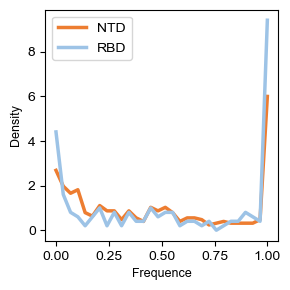

In [20]:
df = pd.read_csv('./density_S.csv', header=0)
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(3,3))

plt.plot(df['x'], df['NTD'], color = '#ED7D31', lw=2.5, zorder=-9, label = 'NTD')
plt.plot(df['x'], df['RBD'], color = '#9DC3E6', lw=2.5, zorder=-9, label = 'RBD')
# plt.plot(df['x'], df['FP'], color = '#FFE699', lw=2, zorder=-9, label = 'FP')
# plt.plot(df['x'], df['HR1'], color = '#FFC9B4', lw=2, zorder=-9, label = 'HR1')
# plt.plot(df['x'], df['HR2'], color = '#DAC0B7', lw=2, zorder=-9, label = 'HR2')

plt.xlabel('Frequence', fontsize = 9)
plt.ylabel('Density', fontsize = 9)
plt.legend()

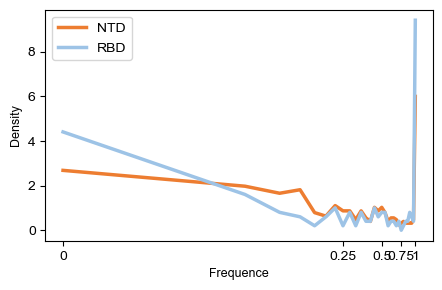

In [57]:
df = pd.read_csv('./density_S.csv', header=0)
plt.rcParams['font.sans-serif'] = ['Arial']

plt.figure(figsize=(5,3))

plt.plot(np.log(df['x']+0.001), df['NTD'], color = '#ED7D31', lw=2.5, zorder=-9, label = 'NTD')
plt.plot(np.log(df['x']+0.001), df['RBD'], color = '#9DC3E6', lw=2.5, zorder=-9, label = 'RBD')
# plt.plot(df['x'], df['FP'], color = '#FFE699', lw=2, zorder=-9, label = 'FP')
# plt.plot(df['x'], df['HR1'], color = '#FFC9B4', lw=2, zorder=-9, label = 'HR1')
# plt.plot(df['x'], df['HR2'], color = '#DAC0B7', lw=2, zorder=-9, label = 'HR2')

x_index = []
x_log_index = []
x_index.append(0)
x_index.append(0.25)
x_index.append(0.5)
x_index.append(0.75)
x_index.append(1)
x_log_index.append(np.log(df['x'][0]+0.001))
x_log_index.append(np.log(df['x'][7]+0.001))
x_log_index.append(np.log(df['x'][15]+0.001))
x_log_index.append(np.log(df['x'][22]+0.001))
x_log_index.append(np.log(df['x'][29]+0.001))

plt.xticks(x_log_index, x_index)
plt.xlabel('Frequence', fontsize = 9)
plt.ylabel('Density', fontsize = 9)
plt.legend()

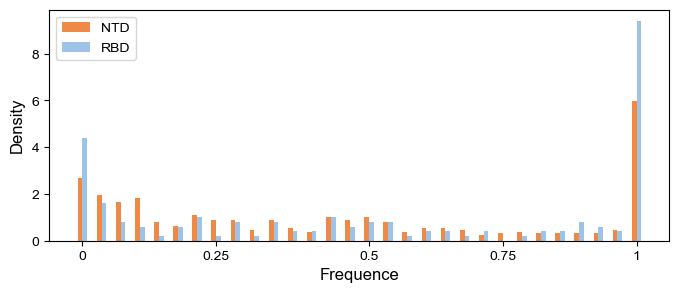

In [58]:
plt.rcParams['font.sans-serif'] = ['Arial']
df = pd.read_csv('./density_S.csv', header = 0)

plt.figure(figsize=(8,3))
# 输入统计数据
# x_label = ('USA', 'UK', 'Germany', 'Japan', 'Denmark')
x_label = round(df['x'], 1)
# sigma_Eu = np.array([2318360, 1373231, 561641, 402008, 354447])
sigma_Eu = df['NTD']
# sigma_Pu= np.array([2431934, 1689880, 371358, 233567, 247520])
sigma_Pu = df['RBD']

bar_width = 0.25  # 条形宽度
index_sigma_Eu = np.arange(len(sigma_Eu))  # 训练集条形图的横坐标
index_sigma_Pu = index_sigma_Eu + bar_width  # 测试集条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_sigma_Eu, height=sigma_Eu, width=bar_width, label='NTD', color = '#ED7D31', alpha = 0.9)
plt.bar(index_sigma_Pu, height=sigma_Pu, width=bar_width, label='RBD', color = '#9DC3E6')

plt.legend(loc="upper left")  # 显示图例  设置图例的大小和方向

x_label_print = []
x_loc_print = []
x_label_print.append(0)
x_label_print.append(0.25)
x_label_print.append(0.5)
x_label_print.append(0.75)
x_label_print.append(1)
x_loc_print.append(index_sigma_Eu[0] + bar_width / 2)
x_loc_print.append(index_sigma_Eu[7] + bar_width / 2)
x_loc_print.append(index_sigma_Eu[15] + bar_width / 2)
x_loc_print.append(index_sigma_Eu[22] + bar_width / 2)
x_loc_print.append(index_sigma_Eu[29] + bar_width / 2)


# plt.xticks(index_sigma_Eu + bar_width / 2, x_label)
plt.xticks(x_loc_print, x_label_print)
# plt.ylim([0, 0.02])
plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Frequence', fontsize = 12)
plt.ylabel('Density', fontsize = 12)

plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
# plt.show()

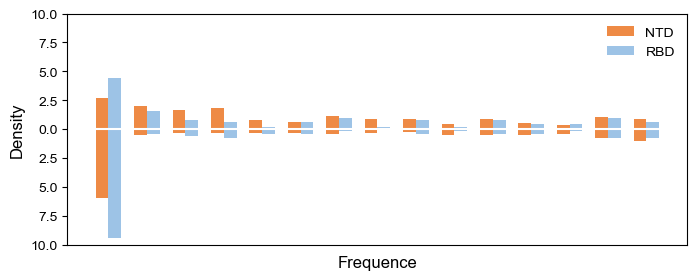

In [93]:
df = pd.read_csv('./density_S1.csv', header = 0)

plt.figure(figsize=(8,3))
plt.rcParams['font.sans-serif'] = ['Arial']
# 输入统计数据
# sigma_Eu = np.array([2318360, 1373231, 561641, 402008, 354447])
sigma_Eu = df['NTD']
# sigma_Pu= np.array([2431934, 1689880, 371358, 233567, 247520])
sigma_Pu = df['RBD']

bar_width = 0.2  # 条形宽度
index_sigma_Eu = np.arange(len(sigma_Eu)/2)*0.6  # 训练集条形图的横坐标
index_sigma_Pu = index_sigma_Eu + bar_width  # 测试集条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_sigma_Eu, height=sigma_Eu[:15], width=bar_width, label='NTD', color = '#ED7D31', alpha = 0.9)
plt.bar(index_sigma_Eu, height=-sigma_Eu[15:], width=bar_width, color = '#ED7D31', alpha = 0.9)
plt.bar(index_sigma_Pu, height=sigma_Pu[:15], width=bar_width, label='RBD', color = '#9DC3E6')
plt.bar(index_sigma_Pu, height=-sigma_Pu[15:], width=bar_width, color = '#9DC3E6')

plt.legend(loc="upper right", frameon=False)  # 显示图例  设置图例的大小和方向

x_label_print = []
x_loc_print = []
# x_label_print.append(0)
# x_label_print.append(0.143)
# x_label_print.append(0.286)
# x_label_print.append(0.428)
# x_label_print.append(0.5)
# x_label_print.append(0.75)
# x_label_print.append(1)
# x_loc_print.append(index_sigma_Eu[0] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[4] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[8] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[12] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[14] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[22] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[29] + bar_width / 2)


# plt.xticks(index_sigma_Eu + bar_width / 2, x_label)
plt.xticks(x_loc_print, x_label_print)
plt.xticks(x_loc_print, [])
plt.yticks([-10.0,-7.5,-5.0,-2.5,0.0,2.5,5.0,7.5,10.0], [10.0,7.5,5.0,2.5,0.0,2.5,5.0,7.5,10.0])
plt.ylim([-10, 10])
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
plt.xlabel('Frequence', fontsize = 12)
plt.ylabel('Density', fontsize = 12)

# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
plt.axhline(y=0,color='white')
# plt.show()

Text(0, 0.5, 'Density')

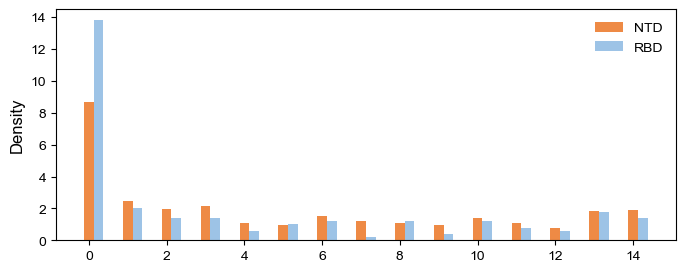

In [2]:
plt.rcParams['font.sans-serif'] = ['Arial']
df = pd.read_csv('./density_S2.csv', header = 0)

plt.figure(figsize=(8,3))
# 输入统计数据
# x_label = ('USA', 'UK', 'Germany', 'Japan', 'Denmark')
x_label = round(df['x'], 1)
# sigma_Eu = np.array([2318360, 1373231, 561641, 402008, 354447])
sigma_Eu = df['NTD']
# sigma_Pu= np.array([2431934, 1689880, 371358, 233567, 247520])
sigma_Pu = df['RBD']

bar_width = 0.25  # 条形宽度
index_sigma_Eu = np.arange(len(sigma_Eu))  # 训练集条形图的横坐标
index_sigma_Pu = index_sigma_Eu + bar_width  # 测试集条形图的横坐标

# 使用两次 bar 函数画出两组条形图
plt.bar(index_sigma_Eu, height=sigma_Eu, width=bar_width, label='NTD', color = '#ED7D31', alpha = 0.9)
plt.bar(index_sigma_Pu, height=sigma_Pu, width=bar_width, label='RBD', color = '#9DC3E6')

plt.legend(loc="upper right", frameon=False)  # 显示图例  设置图例的大小和方向

# x_label_print = []
# x_loc_print = []
# x_label_print.append(0)
# x_label_print.append(0.25)
# x_label_print.append(0.5)
# x_loc_print.append(index_sigma_Eu[0] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[7] + bar_width / 2)
# x_loc_print.append(index_sigma_Eu[14] + bar_width / 2)

# plt.xticks(x_loc_print, x_label_print)
# plt.xticks([])
# plt.ylim([0, 0.02])
# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
# plt.xlabel('Frequence', fontsize = 12)
plt.ylabel('Density', fontsize = 12)

# plt.ticklabel_format(axis="y", style="sci", scilimits=(0,0), useMathText=True)
# plt.show()

In [60]:
from scipy.stats import skew
import numpy as np

df = pd.read_csv('./density_S.csv', header=0)
dseries=df['NTD']
skewness = skew(dseries)
print(skewness)
from scipy.stats import kstest
kstest(df['RBD'],cdf = "norm")

3.3867108642130845


KstestResult(statistic=0.5459370421571965, pvalue=6.498153599328039e-09, statistic_location=0.200027276, statistic_sign=-1)